In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

In [2]:
import spacy
spacy.load('de')

# Data Preparation

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/german_pre_trained/data/")

In [5]:
LM_PATH=Path('lm/german_pre_trained/german_lm/')
LM_PATH.mkdir(exist_ok=True)

In [6]:
# download files from http://lernapparat.de/german-lm/

In [7]:
def get_texts(df, n_lbls=1, lang='de'):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang=lang).proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls, lang='de'):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls, lang=lang)
        tok += tok_;
        labels += labels_
    return tok, labels

In [31]:
itos = pickle.load(open(LM_PATH/'DE_spacy_itos.pkl', 'rb'))
len(itos)

60002

In [34]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [ ]:
lr=8
#lrs = lr

In [ ]:
#learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # train emneddings

# Extract Embeddings from Language Model
The following code can be used to extract the embeddings from the language model (once the dataset has been loaded)

In [52]:
#Test from Thomas
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.1 # if you're overfitting, increase this. Underfitting? decrease this.

md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [56]:
md

In [57]:
# Monkey-patch because model was trained with a newer version.
# See https://discuss.pytorch.org/t/question-about-rebuild-tensor-v2/14560
import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2


In [87]:
#extract encoder from language model
learner.load('DE_model_dropout_0.1_1cycle_10epochs')
learner.save_encoder('DE_model_dropout_0.1_1cycle_10epochs_enc')

In [58]:
m = learner.model
m.eval()
layers = list(m.children())
#dir(layers[0].encoder)
layers[0].encoder.weight

Parameter containing:
-1.7600e-01 -9.5943e-01  6.3313e-01  ...   6.9978e-01  1.2905e-01 -1.0311e-01
-6.4968e-02  2.9150e-02 -8.6607e-02  ...   5.4249e-03 -5.1052e-02 -5.9603e-02
-1.3768e+00 -4.7357e-01  8.7793e-01  ...   5.5475e-01  1.8340e-01 -3.8440e-01
                ...                   ⋱                   ...                
-3.1682e-02  2.5777e-02 -4.2253e-02  ...  -1.1167e-04 -2.2643e-01  2.3541e-02
-2.6808e-01  7.8313e-02 -2.1451e-01  ...  -4.0067e-01 -6.2112e-01  2.2339e-01
-1.0990e-02  2.3592e-01 -1.3663e-01  ...  -1.3740e-01  1.2698e+00  1.3448e-01
[torch.FloatTensor of size 60002x400]

# Test predictions on Language Model

In [59]:
learner.load('DE_model_dropout_0.1_1cycle_10epochs')
m = learner.model
m.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [60]:
sen = "ich stehe in"
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[  654, 10417,     7]])

In [61]:
p = m(VV(idxs))
type(p), len(p)

(tuple, 3)

In [62]:
p[0].shape, [x.shape for x in p[1]], [x.shape for x in p[2]]

(torch.Size([3, 60002]),
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])],
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])])

In [63]:
#p[0] is most likely the output vector
p[0].data


 1.2348e+01 -2.0259e+00  1.0245e+01  ...   2.6298e+00 -2.0552e+00 -2.5068e+00
 1.1451e+01 -1.9301e+00  1.0458e+01  ...  -1.3245e-01 -1.9243e+00 -2.1365e+00
 1.1041e+01 -1.4154e+00  5.9423e+00  ...  -1.8827e+00  6.4855e-01 -2.9854e-02
[torch.FloatTensor of size 3x60002]

In [64]:
# This command gives us the index of the word which has the highest probability for the last row
torch.topk(p[0][-1], 1)

(Variable containing:
  11.6435
 [torch.FloatTensor of size 1], Variable containing:
  11
 [torch.LongTensor of size 1])

In [65]:
#predict the next word
itos[torch.topk(p[0][-1], 1)[1].data[0]]

'den'

In [66]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        print("input: [", inp, "] ||| c:[", c, "]")
        #pdb.set_trace()
        # res += c # ???
        res = res + " " + c
        #pdb.set_trace()
#         inp = ' '.join(inp.strip().split(" ")[1:]) + "  " + c
        inp = inp + " " + c
        inp = ' '.join(inp.strip().split(" ")[-5:]) + "  " + c
        
    return res

In [68]:
sen = "ich wohne in"

# o = get_next(sen)
o = get_next_n(sen, 10)
print(o)

input: [ ich wohne in ] ||| c:[ den ]
input: [ ich wohne in den  den ] ||| c:[ _unk_ ]
input: [ in den  den _unk_  _unk_ ] ||| c:[ . ]
input: [ den _unk_  _unk_ .  . ] ||| c:[ 

 ]
input: [  _unk_ .  .  

 ] ||| c:[ 

 ]
input: [ _unk_ .  .  

 ] ||| c:[ 

 ]
input: [ _unk_ .  .  

 ] ||| c:[ 

 ]
input: [ _unk_ .  .  

 ] ||| c:[ 

 ]
input: [ _unk_ .  .  

 ] ||| c:[ 

 ]
input: [ _unk_ .  .  

 ] ||| c:[ 

 ]
ich wohne in den _unk_ . 

 

 

 

 

 

 




In [69]:
# more intereference tests
def get_next(inp):
    m[0].bs =1
    #print(inp)
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        # res += c # ???
        res = res + " " + c
        #print(res)
        inp = inp.strip().split(" ") + [c]        
#         inp = ' '.join(inp[1:])
        inp = ' '.join(inp)
        
    return res

In [72]:
sen = "wenn die sonne scheint ist es" 
get_next_n(sen, 10)

'wenn die sonne scheint ist es ist die _unk_ . \n\n \n\n \n\n \n\n \n\n \n\n'

# Classifier Tokens
The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [15]:
CLAS_PATH = Path("lm/german_pre_trained/german_twitter_clas/")
CLAS_PATH.mkdir(exist_ok=True)

In [16]:
df_clas_data = pd.read_csv(CLAS_PATH/"downloaded.tsv", sep="\t", header=None)
df_clas_data = df_clas_data[[1,4]]
df_clas_data.columns = ['sentiment', 'tweet_text']

df_clas_data.applymap(lambda x: x.strip() if type(x) is str else x)
df_clas_data = df_clas_data[df_clas_data.tweet_text.str.contains("Not Available") == False]

mapping = {'negative': 0, 'neutral': 1, 'positive': 2, }
df_clas_data = df_clas_data.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
df_clas_data['sentiment'] = df_clas_data['sentiment'].astype(np.float32)

In [17]:
# copy-past from https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/preprocess.py
import re

import re
import sys


def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [18]:
df_clas_data['tweet_text'] = df_clas_data['tweet_text'].apply(lambda x: preprocess_tweet(x))

In [19]:
#remove neutral comments
#df_clas_data = df_clas_data[df_clas_data['sentiment'] != 0].reset_index(drop=True)

df_clas_data.to_csv(CLAS_PATH/"German_Sentiment_Data.csv", index=False)

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"German_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"German_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

(6382, 748)

In [20]:
#Number of tweets per sentiment
df_clas_data['sentiment'].value_counts()

1.0    4415
2.0    1637
0.0    1078
Name: sentiment, dtype: int64

In [21]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"German_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"German_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [22]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [23]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [24]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [27]:
itos = pickle.load((LM_PATH/'DE_spacy_itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [28]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [29]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier
We build a classifier to make sentiment predictions on the SB-10k Twitter Corpus (https://www.spinningbytes.com/resources/germansentiment/) using our language model

In [1]:
from fastai.text import * 
import json
import pathlib


import numpy as np
import pandas as pd

PATH = pathlib.Path("lm/german_pre_trained/data/")

LM_PATH=Path('lm/german_pre_trained/german_lm/')
LM_PATH.mkdir(exist_ok=True)
CLAS_PATH = Path("lm/german_pre_trained/german_twitter_clas/")
CLAS_PATH.mkdir(exist_ok=True)
itos = pickle.load(open(LM_PATH/'DE_spacy_itos.pkl', 'rb'))

In [2]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [3]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [4]:
#length of first comment
len(trn_clas[0])

21

In [5]:
wd=1e-7

In [6]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.SGD, momentum=0.9, weight_decay=wd)
bs = 48

In [7]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [8]:
c

3

We need to classify the sentiment of the data into either positive / neutral / negative (number of classes c = 3).

In [9]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [10]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])*0.5

In [11]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [12]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [13]:
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
#lr=3e-3
#lrm = 2.6
#lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [14]:
learn.load_encoder('DE_model_dropout_0.1_1cycle_10epochs_enc')

In [15]:
learn.freeze_to(-1)

 90%|████████▉ | 239/266 [03:34<00:24,  1.11it/s, loss=9.68] 

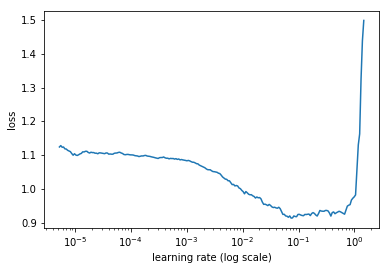

In [16]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [17]:
# learning rate from learning rate finder
lr=1e-2 # from lr_find
learn.fit(lr, 1, wds=wd, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.820719   0.801989   0.634843  


[array([0.80199]), 0.6348425196850394]

In [18]:
#learn.save('clas_0')
#learn.save_encoder('clas_0_enc')

In [19]:
#learn.load('clas_0')

In [20]:
learn.freeze_to(-2)

In [21]:
learn.fit(lr, 1, wds=wd, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.808825   0.788451   0.637467  


[array([0.78845]), 0.6374671916010499]

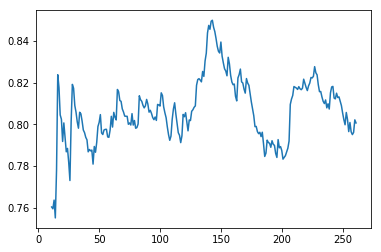

In [22]:
learn.sched.plot_loss()

In [23]:
#learn.save('clas_1')

In [24]:
#learn.load('clas_1')

In [25]:
learn.unfreeze()

In [26]:
learn.fit(lr, 1, wds=wd, cycle_len=15, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.801598   0.788156   0.640994  
    1      0.760427   0.786607   0.639928                    
    2      0.787289   0.758858   0.665272                    
    3      0.772157   0.775284   0.659941                    
    4      0.753498   0.751667   0.664206                    
    5      0.778988   0.761916   0.661909                    
    6      0.731497   0.754992   0.669701                    
    7      0.751454   0.756861   0.671424                    
    8      0.731529   0.756769   0.648622                    
    9      0.722801   0.753607   0.660515                    
    10     0.723174   0.75458    0.660925                    
    11     0.716562   0.751732   0.659613                    
    12     0.703554   0.747442   0.669455                    
    13     0.714838   0.752448   0.664124                    
    14     0.707337   0.750195   0.664206                    


[array([0.7502]), 0.6642060367454069]

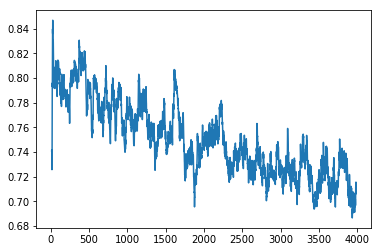

In [27]:
learn.sched.plot_loss()

In [28]:
learn.save('clas_pretrained')

# Experiments
For validation purposes, we try to manually get predictions from the classifier

In [29]:
#get predictions from evaluation set
pred_pred = learn.predict()

In [30]:
pred = Variable(torch.from_numpy(pred_pred))

In [31]:
#convert prediction into probababilities
prob = F.softmax(pred)
print(prob)

Variable containing:
 0.4360  0.2332  0.3308
 0.1268  0.3727  0.5005
 0.1068  0.4984  0.3948
           ⋮            
 0.3289  0.4578  0.2133
 0.2509  0.4245  0.3246
 0.4142  0.3714  0.2144
[torch.FloatTensor of size 748x3]



In [32]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.05)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=3, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm

In [35]:
# perform manual prediction on the validation set 
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
learn.load('clas_pretrained')
m = learn.model
#set batch size to 1
m[0].bs=1
#turn off dropout
i = 0
results = []
while i < len(tok_val):
    #print(i)
    sen = ' '.join(tok_val[i])
    i+=1
    m.eval()
    #reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    #get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])


 xbos xfld 1 breitet sich aus: [0]

 xbos xfld 1 die app hat mir mb belegten speicher freigemacht das dieser app bringt mir mb freien speicher und: [1]

 xbos xfld 1 t_up user_mention honess bekommt ne sehr hohe gesldstrafe und das max an: [2]

 xbos xfld 1 t_up user_mention hmm vielleicht fehlt dir der glaube oder du hast einfach die falsche t_up emo_pos: [2]

 xbos xfld 1 welches geschenk hast du zuletzt bekommen eine bettdecke o.o t_up url: [1]

 xbos xfld 1 gewinnspielteilnahme gratis mit eine playstation gewinnen t_up url gewinnspiel: [1]

 xbos xfld 1 den ganzen tag wildwasserbahn fahren war vielleicht doch nicht soo gut: [2]

 xbos xfld 1 t_up user_mention warum sollte eine freund_innenschaft nicht romantisch sein: [1]

 xbos xfld 1 t_up user_mention serie was braucht an die politik t_up url nrw13 und brauchen auch irgendwelche frauen was: [1]

 xbos xfld 1 nein unterirdisch t_up user_mention politisch bleibt also in alles anders: [1]

 xbos xfld 1 guten morgen schon novemberli


 xbos xfld 1 menschen aus fanlagern vereint in ihrem hohn schalke d: [1]

 xbos xfld 1 google will angeblich eigenes auto entwickeln google will angeblich ein aut t_up url schnipselnachrichten: [1]

 xbos xfld 1 die neue mega social network sharing community jetzt schon weit aus mehr member als facebook twitter zusammen t_up url: [1]

 xbos xfld 1 t_up user_mention von denen wird mir immer schlecht: [1]

 xbos xfld 1 t_up user_mention partnerschafte funktionieret well dmensche scheisse sind: [1]

 xbos xfld 1 abendliche t_up url: [1]

 xbos xfld 1 endlich mal ne frau die auch noch autofahren kann t_up url rtl: [1]

 xbos xfld 1 t_up user_mention csu stillstand afd nahe zu ins mittelalter: [1]

 xbos xfld 1 intersnack chio mikrowellen popcorn karamellgeschmack neue sorte das t_up url: [1]

 xbos xfld 1 ganz windig heute herbst sturm leipzig wetter weather in zschortau via instaweather t_up url: [1]

 xbos xfld 1 ns verstoring enschededeventer defecte trein info t_up url: [1]

 xbos xfl


 xbos xfld 1 stilvoll parisbilder bearbeiten paris bildbearbeitung lightroom endlichkommichdazu t_up url: [1]

 xbos xfld 1 t_up user_mention da komm ich bei dir vorbei und schleuder dir ein schnitzel ins gesicht: [1]

 xbos xfld 1 plakate plakativ gedruckt unsere topangebot noch bis ende september t_up url: [1]

 xbos xfld 1 scheitert zusammenarbeit am geld t_up url: [1]

 xbos xfld 1 apple stellt video der iphone keynote bereit t_up url: [1]

 xbos xfld 1 t_up user_mention waab: [0]

 xbos xfld 1 t_up user_mention come on boys nicht zu hoch verlieren fcn sgefcn: [2]

 xbos xfld 1 t_up user_mention nur eins virals tot nicht mehr reden: [1]

 xbos xfld 1 stunden marathon sind nicht gerade spannend lieber scrubs schauen scrubs marathon leichtathletikwm: [2]

 xbos xfld 1 passiver bi mann schutterwald bi mann sucht aktive nicht zu jung t_up url: [1]

 xbos xfld 1 ich schlorender in de fress da hast de mehr wie de porta nigra trierisch: [2]

 xbos xfld 1 spenden zum monat der weltmission


 xbos xfld 1 t_up user_mention ebru was mach ich falsch bei deinem neuen video kommt bei mir wieder kein ton t_up emo_neg: [2]

 xbos xfld 1 vorbildlich costa rica will seine zoos bis aus t_up url tierschutz: [1]

 xbos xfld 1 t_up user_mention haha auch nicht schlecht xd naja nicht fand sie iwie immer cool lustig frech xd hat nur doofe halt xd haha: [2]

 xbos xfld 1 t_up url fabelhaft gebrochene karrieren: [1]

 xbos xfld 1 t_up user_mention why no phone again: [2]

 xbos xfld 1 t_up user_mention gaul abis: [0]

 xbos xfld 1 schade bei vivas bully beatdown wird garnicht der typ aus schuh des manitu zusammengeschlagen: [1]

 xbos xfld 1 streetstars vergibt unter allen vip bewerbungen vip auf den tuningdays austria mehr infos auf t_up url: [1]

 xbos xfld 1 woods auf nach gespielten bahnen liegt er beim wgc bridgestone invitational die runde come on tiger da geht was: [2]

 xbos xfld 1 t_up user_mention einsteigen in den hyperloop mit von san francisco nach la in minuten leider bisher


 xbos xfld 1 play together brickforce mist zu weit vom mikro weg t_up url t_up user_mention: [1]

 xbos xfld 1 und wenn der tweet auch noch so schlecht ist von meinen homies aus dem fdportsverband gibts immer nen stern oh: [2]

 xbos xfld 1 kinderkanal piets irre pleiten motorvision motorheads n24 nachrichten lucky fred ntv nachrichten rbb rbb aktuell: [1]

 xbos xfld 1 tk_wrep 7 t_up user_mention ich brauche ein bier: [2]

 xbos xfld 1 t_up user_mention nsa chef keith alexander verteidigt und fordert ende der t_up url nd: [1]

 xbos xfld 1 mir sitzt einer mit nem it should was der wohl n beruf hat: [2]

 xbos xfld 1 t_up user_mention und genug gezappelt t_up emo_pos kaffee jetzt gut oder: [2]

 xbos xfld 1 guten wochenstart euch allen aus t_up url: [2]

 xbos xfld 1 kostenexplosion bei bil dollar uskriegsinvaliden den drang zu t_up url: [1]

 xbos xfld 1 brauch ablenkung: [1]

 xbos xfld 1 faule werden neue ezbchef draghi definition notleidender kredite muss harmonisiert werden vor m


 xbos xfld 1 hotpaar37 regensburg attraktives m besuchen gegen tg den solventen herren oder kleine he t_up url: [1]

 xbos xfld 1 t_up user_mention bundestagswahl prozent der wahlberechtigten sind nicht i m bundestag vertreten btw13 cdu spd linke t_up url: [1]

 xbos xfld 1 t_up user_mention schraibn o bin in letzter zeit viel mit anderen leuten am: [1]

 xbos xfld 1 schmuck sal y limon armreif seit verzaubert sal y limon mit verspielten kreationen spannende l t_up url: [1]

 xbos xfld 1 t_up user_mention ich danke t_up emo_pos: [2]

 xbos xfld 1 nachrichten jenny elverselbertzhag t_up url: [1]

 xbos xfld 1 also gleich irgendwann wenns fertig geladen ist update android: [1]

 xbos xfld 1 t_up user_mention verzweifelte rettungsversuche: [0]

 xbos xfld 1 feuerwehr aufmerksame nachbarn t_up url: [1]

 xbos xfld 1 neuschwanstein castle germany t_up url: [1]

 xbos xfld 1 aktien euro bernanke sorgt katerstimmung bei daxanlegern die unklarheit den t_up url aktuell: [1]

 xbos xfld 1 unter


 xbos xfld 1 einsteiger brauche dringend hilfe autor vollmond12345 t_up url: [1]

 xbos xfld 1 tvonline live eintracht braunschwe eintracht braunschweig gegen fsv frankfurt live streaming t_up url: [1]

 xbos xfld 1 t_up url challenge accepted hoffentlich bekomm ich das sonntag so hin a dojaku: [1]

 xbos xfld 1 vom aus helge schneider beim soundcheck funny: [1]

 xbos xfld 1 einsicht fallen: [1]

 xbos xfld 1 vorwahlen in new york skandalpolitiker weiner kann nicht mehr werden t_up url: [1]

 xbos xfld 1 t_up user_mention ne da muss ich wohl flitzen eben t_up emo_pos: [2]

 xbos xfld 1 gezeichnetes gemaltes portrait musiker bands adoode.de kostenlose kleinanzeigen verweile doc t_up url: [1]

 xbos xfld 1 t_up user_mention finde raabs naive art nachzufragen super tvduell: [2]

 xbos xfld 1 schicke oldenburger freren zuchtstute dklbraun wegen aufgabe der zucht guenstig abzugeben vs t_up url: [1]

 xbos xfld 1 flotter dreier mit geilen schlampen category amateure deutsche pornos gangban


 xbos xfld 1 endlich da breaking bad methlabor aus lego filed under spielzeug ob t_up url breakingbad breakingbad citizenbrick: [1]

 xbos xfld 1 t_up user_mention vielen dank folgen meiner tweets mehr infos gerne auch unter dem account unserer agentur t_up user_mention t_up emo_pos vg aus: [1]

 xbos xfld 1 t_up user_mention das wiederum verstehe ich jetzt nicht: [0]

 xbos xfld 1 uni wien gegen rechte hetze aller art utl uni wien ruft auf rechtsextremismus keinen platz t_up url apa ots: [1]

 xbos xfld 1 wein i m kopf get lucky in dauerschlaufe auffe ohren ist ihnen auch schon mal aufgefallen dass daft punk immer ein zu lang ist: [1]

 xbos xfld 1 ehm oder ab zeit hab am xp zeitlich von um an ab mir eig und liebsten: [1]

 xbos xfld 1 diet diet diet kein essen kein essen: [0]

 xbos xfld 1 meine paranoia ist allgemein bekannt snowden brauchte die besten journalisten t_up url via t_up user_mention: [1]

 xbos xfld 1 t_up user_mention anschluss kaputt: [0]

 xbos xfld 1 klassischer en


 xbos xfld 1 t_up user_mention das klingt richtig gut was eine hast du denn u v u: [2]

 xbos xfld 1 alkohol jetzt mehr alkohol sofort: [1]

 xbos xfld 1 t_up user_mention guten morgen tag i m nsuprozess gleich kommt eine wichtige belastungszeugin die laut anklage am tatort in: [2]

 xbos xfld 1 lieben vermissen weinen springen sterben t_up url: [1]

 xbos xfld 1 bildplus inhalt kevinprince boateng bayern sind gru t_up url bayern bildplus boateng diese gruselig: [1]

 xbos xfld 1 heimarbeit alle die am pc geld verdienen gratis info t_up url: [1]

 xbos xfld 1 fussball initiative pyroausschreitungen t_up url: [1]

 xbos xfld 1 nach oblivion nun autorennen cruise kosinski planen go like hell t_up url: [1]

 xbos xfld 1 mobil t_up url: [1]

 xbos xfld 1 stand der dinge hahn kein ei auslauf wird morgen fertig polly keinerlei mehr: [1]

 xbos xfld 1 t_up user_mention immer wieder gerne gefragt auf familienfesten wann wollt ihr eigentlich mal kinder bekommen wir sammeln antworten: [1]

 xbo

In [36]:
# single prediction
learn.load('clas_pretrained')
m = learn.model
#set batch size to 1
m[0].bs=1
#turn off dropout
m.eval()
#reset hidden state
m.reset()  

#sentence to be classified
sen = "guten morgen schon novemberlicht da mag man gar nicht glauben was gestern wetter war"
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])

#converting sentence into numerical representation
print('numeric representation: ' + str(idxs))
idxs = np.transpose(idxs)

#get predictions from model
p = m(VV(idxs))
print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))

numeric representation: [[ 1611  2295   179     0    97  5670    96  1668    47  2236   180 28919  5816    33]]
guten morgen schon novemberlicht da mag man gar nicht glauben was gestern wetter war: [0]


In [37]:
# val_labels are the labels from the dataset
print(len(val_labels))
# results are the predicted results
print(len(results))

748
748


In [38]:
preds = np.asarray(results)

In [45]:
from sklearn.metrics import *
# f1 score for all three classes
f1_score(val_labels, preds, average='weighted')

0.6071451892394497

In [46]:
print(classification_report(val_labels, preds))

             precision    recall  f1-score   support

          0       0.30      0.11      0.16       133
          1       0.72      0.84      0.78       457
          2       0.47      0.51      0.49       158

avg / total       0.60      0.64      0.61       748



In [47]:
print(confusion_matrix(val_labels, preds))

[[ 15  78  40]
 [ 25 383  49]
 [ 10  68  80]]
